In [1]:
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

abbreviation key

gp = games played

net_rating = offRating - defRating

offRating = 100*((points)/POSS)

defRating = 100*((opp points/(opp POSS)))

oreb_pct = offensive rebound percentage

usg_pct = usage percentage is a measurement of the percentage of team plays utilized by a player while they are in the game

ts_pct = true shooting percentage.  percentage of shots made factoring in threes and free throws.  

ast_ptg = assist percentage.  Percent of field goals (2 or 3 point shots not including free throws) 





In [2]:
# !wget https://github.com/morganjng/nba-classifier/blob/main/all_seasons.csv
csv = pd.read_csv("all_seasons.csv")

In [3]:
total_players = len(csv["player_name"])
print(csv.columns, total_players)
for col in csv.columns:
    print(csv[col][0])

Index(['Unnamed: 0', 'player_name', 'team_abbreviation', 'age',
       'player_height', 'player_weight', 'college', 'country', 'draft_year',
       'draft_round', 'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating',
       'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object') 11700
0
Travis Knight
LAL
22.0
213.36
106.59412
Connecticut
USA
1996
1
29
71
4.8
4.5
0.5
6.2
0.127
0.182
0.142
0.536
0.052
1996-97


In [4]:
colleges = []
countries = []
years = []
seasons = []
teams = []
for i in range(0, total_players):
  if(csv["college"][i] not in colleges):
    colleges.append(csv["college"][i])
  if(csv["country"][i] not in countries):
    countries.append(csv["country"][i])
  if(csv["draft_year"][i] not in colleges):
    years.append(csv["draft_year"][i])
  if(csv["season"][i] not in seasons):
    seasons.append(csv["season"][i])
  if(csv["team_abbreviation"][i] not in teams):
    teams.append(csv["team_abbreviation"][i])
print(colleges, countries, years, seasons, teams)

['Connecticut', 'North Carolina-Wilmington', 'Iowa', 'Providence', 'None', 'Seward County Community College', 'Old Dominion', 'Temple', 'Georgia Tech', "St. John's (NY)", 'Washington State', 'Texas Tech', 'Seton Hall', 'American International', 'Massachusetts', 'Murray State', 'Drexel', 'Louisiana State', 'Long Beach State', 'New Mexico', 'Michigan', 'Pennsylvania', 'Michigan State', 'Missouri', 'Louisville', 'Georgetown', 'Louisiana Tech', 'Arkansas', 'Virginia', 'Cincinnati', 'Illinois', 'North Carolina State', 'Montevallo', 'Stetson', 'Wake Forest', 'West Florida', 'Notre Dame', 'UCLA', 'Kansas State', 'George Washington', 'North Carolina', 'Xavier', 'Wisconsin', 'Georgia Southern', 'San Diego State', 'Oklahoma', 'Memphis', 'Mt. San Antonio', 'Alabama', 'Arizona', 'Richmond', 'Syracuse', 'Gonzaga', 'Oklahoma State', 'Detroit Mercy', 'Arkansas-Little Rock', 'Maryland', 'McNeese State', 'Southern Mississippi', 'Purdue', 'Virginia Tech', 'Marquette', 'Ohio State', 'Georgia', 'La Salle'

In [5]:
sum_round = 0
count_round = 0
sum_number = 0
count_number = 0
for i in range(0, total_players):
  if(csv["draft_number"][i] != "Undrafted"):
    sum_number += int(csv["draft_number"][i])
    count_number += 1
  if(csv["draft_round"][i] != "Undrafted"):
    sum_round += int(csv["draft_round"][i])
    count_round += 1

mean_round = sum_round / count_round
mean_number = sum_number / count_number
print(mean_round, mean_number)

1.3026233603997501 21.783007080383175


In [6]:
for i in range(0, total_players):
  if(csv["draft_number"][i] == "Undrafted"):
    csv["draft_number"][i] = mean_number
  if(csv["draft_round"][i] == "Undrafted"):
    csv["draft_round"][i] = mean_round

/tmp/ipykernel_3337/2124559815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv["draft_number"][i] = mean_number
/tmp/ipykernel_3337/2124559815.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv["draft_round"][i] = mean_round


In [7]:
def one_hot(value, array):
  v = [0 for i in range(len(array))]
  v[array.index(value)] = 1
  return torch.Tensor(v)

Data Preprocessing

In [8]:
def random_split(test_percent):
  test_amount = int(total_players * test_percent)
  test_sample = random.sample(range(0,total_players), test_amount)
  train_sample = [i for i in range(0, total_players)]
  test_x = []
  test_y = []
  train_x = []
  train_y = []
  for idx in test_sample:
    train_sample.remove(idx)
    test_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
    test_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
  for idx in train_sample:
    train_x.append([one_hot(csv["team_abbreviation"][idx], teams), one_hot(csv["college"][idx], colleges), one_hot(csv["country"][idx], countries),
                   one_hot(csv["draft_year"][idx], years), one_hot(csv["season"][idx], seasons), float(csv["age"][idx]),
                   float(csv["player_height"][idx]), float(csv["player_weight"][idx]), float(csv["draft_round"][idx]), float(csv["draft_number"][idx]),
                   float(csv["gp"][idx]), float(csv["net_rating"][idx]), float(csv["usg_pct"][idx])])
    train_y.append(torch.Tensor([float(csv["pts"][idx]), float(csv["reb"][idx]),
                   float(csv["ast"][idx]), float(csv["oreb_pct"][idx]), float(csv["dreb_pct"][idx]), float(csv["ts_pct"][idx]), float(csv["ast_pct"][idx])]))
  return train_x, train_y, test_x, test_y

In [9]:
%time train_x, train_y, test_x, test_y = random_split(0.2)

CPU times: user 9.63 s, sys: 264 ms, total: 9.89 s
Wall time: 9.83 s


In [10]:
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))

9360 9360
2340 2340


Training

In [12]:
def train(neural_net, optimizer, loss, scheduler, train_features, train_labels, epochs, batch_size, dropout=False):
  xs = [[] for i in range(epochs)]
  ys = [[] for i in range(epochs)]
  neural_net.train()
  for epoch in range(epochs):
    count = 0
    rl = 0.0
    optimizer.zero_grad()
    for i in range(len(train_labels)):
      train_y = train_labels[i]
      train_x = train_features[i]
      output = neural_net(train_x)
      out_loss = loss(output, train_y)
      out_loss.backward()
      optimizer.step()
      count += 1
      rl += out_loss.item()
      if count % batch_size == 0:
        optimizer.zero_grad()
        print(str(count) + " completed. Loss: " + str(rl/batch_size))
        xs[epoch].append(count)
        ys[epoch].append(rl/batch_size)
        rl = 0.0
    scheduler.step()
  return xs, ys

In [13]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.teamLin = nn.Linear(len(teams), 1)
    self.collegeLin = nn.Linear(len(colleges), 1)
    self.countryLin = nn.Linear(len(countries), 1)
    self.draftLin = nn.Linear(len(years), 1)
    self.seasonLin = nn.Linear(len(seasons), 1)
    self.sequential = nn.Sequential(
        nn.Linear(13, 20),
        #nn.Dropout(p=0.2),
        nn.Linear(20, 40),
        #nn.Dropout(p=0.2),
        nn.Linear(40, 40),
        #nn.Dropout(p=0.2),
        nn.Linear(40, 40),
        #nn.Dropout(p=0.2),
        nn.Linear(40, 20),
        #nn.Dropout(p=0.2),
        nn.Linear(20, 7),
    )

  def forward(self, x):
    x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
    return self.sequential(x)

In [14]:
class LinearNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.teamLin = nn.Linear(len(teams), 1)
    self.collegeLin = nn.Linear(len(colleges), 1)
    self.countryLin = nn.Linear(len(countries), 1)
    self.draftLin = nn.Linear(len(years), 1)
    self.seasonLin = nn.Linear(len(seasons), 1)
    self.sequential = nn.Sequential(
        nn.Linear(13, 7)
    )

  def forward(self, x):
    x = torch.Tensor([self.teamLin(x[0]), self.collegeLin(x[1]), self.countryLin(x[2]), self.draftLin(x[3]), self.seasonLin(x[4])] + x[5:])
    return self.sequential(x)

In [17]:
neural = NeuralNet()
linnet = LinearNet()
loss = nn.MSELoss()
lin_loss = nn.MSELoss()
lin_optim = optim.Adam(linnet.parameters())
optimizer = optim.Adam(neural.parameters())
n_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [25]:
xs, ys = train(neural, optimizer, loss, n_scheduler, train_x, train_y, 30, 200)

200 completed. Loss: 4.9774973830673845
400 completed. Loss: 3.784033372104168
600 completed. Loss: 3.7344077716208997
800 completed. Loss: 3.8051443555706648
1000 completed. Loss: 3.59155953691341
1200 completed. Loss: 3.5686585773155093
1400 completed. Loss: 3.8229046947788445
1600 completed. Loss: 3.519837479745038
1800 completed. Loss: 3.9213624075008555
2000 completed. Loss: 3.4714549604011697
2200 completed. Loss: 3.584048205576837
2400 completed. Loss: 3.465184519756585
2600 completed. Loss: 3.667901323568076
2800 completed. Loss: 3.584350655162707
3000 completed. Loss: 4.94993894668296
3200 completed. Loss: 3.9165408366988412
3400 completed. Loss: 3.656200190107338
3600 completed. Loss: 4.03343846431002
3800 completed. Loss: 4.281352837802842
4000 completed. Loss: 4.2867395366728305
4200 completed. Loss: 3.5475336947664617
4400 completed. Loss: 4.331654513720423
4600 completed. Loss: 4.36427830491215
4800 completed. Loss: 4.216712399832904
5000 completed. Loss: 3.81098395038396

4200 completed. Loss: 4.126460027815774
4400 completed. Loss: 3.8787734283320607
4600 completed. Loss: 3.750051874599885
4800 completed. Loss: 4.002311382647604
5000 completed. Loss: 3.5561816980643197
5200 completed. Loss: 3.44495613518171
5400 completed. Loss: 3.15101816708222
5600 completed. Loss: 2.763176950532943
5800 completed. Loss: 3.4896498231356965
6000 completed. Loss: 3.157082067336887
6200 completed. Loss: 3.145166535368189
6400 completed. Loss: 3.8718348454125224
6600 completed. Loss: 3.3718437572568654
6800 completed. Loss: 3.137181056048721
7000 completed. Loss: 3.7532712786644695
7200 completed. Loss: 3.5668092641234397
7400 completed. Loss: 3.560485175549984
7600 completed. Loss: 3.267474735341966
7800 completed. Loss: 3.49616450981237
8000 completed. Loss: 3.856033023223281
8200 completed. Loss: 3.834920377098024
8400 completed. Loss: 3.491783110466786
8600 completed. Loss: 3.5636717633064836
8800 completed. Loss: 3.630671450421214
9000 completed. Loss: 4.23849719568

8200 completed. Loss: 3.5006874678848545
8400 completed. Loss: 2.992058396865614
8600 completed. Loss: 3.1939380041323604
8800 completed. Loss: 3.200878359666094
9000 completed. Loss: 3.6093006876762956
9200 completed. Loss: 3.121409763228148
200 completed. Loss: 4.352761319582351
400 completed. Loss: 3.9777548789046704
600 completed. Loss: 3.599147471068427
800 completed. Loss: 3.2866042795963586
1000 completed. Loss: 2.9905560490861536
1200 completed. Loss: 2.927293119505048
1400 completed. Loss: 3.185383331924677
1600 completed. Loss: 2.8100661590881644
1800 completed. Loss: 3.0643645785422997
2000 completed. Loss: 2.845115140359849
2200 completed. Loss: 2.9682305179326796
2400 completed. Loss: 2.635009273844771
2600 completed. Loss: 2.894620020161383
2800 completed. Loss: 2.6139055352518334
3000 completed. Loss: 3.6419708914123476
3200 completed. Loss: 3.086799594014883
3400 completed. Loss: 2.984577136905864
3600 completed. Loss: 3.3665347717609255
3800 completed. Loss: 3.46492352

3000 completed. Loss: 3.403111710175872
3200 completed. Loss: 2.9482610855204983
3400 completed. Loss: 2.847411224339157
3600 completed. Loss: 3.1340811115549876
3800 completed. Loss: 3.3470364409917965
4000 completed. Loss: 3.334179737335071
4200 completed. Loss: 2.854952356686117
4400 completed. Loss: 2.9098367112874985
4600 completed. Loss: 3.0866112653166056
4800 completed. Loss: 3.3182288779318334
5000 completed. Loss: 2.9087535395193846
5200 completed. Loss: 2.704358902005479
5400 completed. Loss: 2.9151013012090696
5600 completed. Loss: 2.4320219538733365
5800 completed. Loss: 3.0216051543317737
6000 completed. Loss: 2.429975641099736
6200 completed. Loss: 2.596383170299232
6400 completed. Loss: 2.71364755803952
6600 completed. Loss: 2.570519579378888
6800 completed. Loss: 2.654107819898054
7000 completed. Loss: 3.0144056958239527
7200 completed. Loss: 2.8848910283623264
7400 completed. Loss: 3.5110609796317296
7600 completed. Loss: 3.202046747957356
7800 completed. Loss: 3.3496

7000 completed. Loss: 2.906378086162731
7200 completed. Loss: 2.635761423818767
7400 completed. Loss: 2.985149060431868
7600 completed. Loss: 2.632029125019908
7800 completed. Loss: 2.8373328613489868
8000 completed. Loss: 3.382413159311982
8200 completed. Loss: 3.2432836296688765
8400 completed. Loss: 2.565210247086361
8600 completed. Loss: 2.8382043437194078
8800 completed. Loss: 2.742281955464277
9000 completed. Loss: 2.960132850809023
9200 completed. Loss: 2.8995315638184547
200 completed. Loss: 3.6024652346875516
400 completed. Loss: 3.104682398373261
600 completed. Loss: 2.8395220782514663
800 completed. Loss: 3.2715275794267655
1000 completed. Loss: 2.800195242098998
1200 completed. Loss: 2.6892444831179456
1400 completed. Loss: 2.9545718101691456
1600 completed. Loss: 2.477392451670021
1800 completed. Loss: 2.7837229643960018
2000 completed. Loss: 2.6671492590382697
2200 completed. Loss: 2.8179521323833616
2400 completed. Loss: 2.3993320389930157
2600 completed. Loss: 2.7994547

1600 completed. Loss: 2.415824693636969
1800 completed. Loss: 2.7504391072224825
2000 completed. Loss: 2.635458842013031
2200 completed. Loss: 2.794037229944952
2400 completed. Loss: 2.356672132811509
2600 completed. Loss: 2.778055783379823
2800 completed. Loss: 2.2930610172171146
3000 completed. Loss: 3.223047074014321
3200 completed. Loss: 2.8584624006040396
3400 completed. Loss: 2.7046642475761473
3600 completed. Loss: 3.004457666594535
3800 completed. Loss: 3.0578306037094443
4000 completed. Loss: 3.3006703472463412
4200 completed. Loss: 2.4791645239817446
4400 completed. Loss: 2.8889250380545857
4600 completed. Loss: 3.0228398274537174
4800 completed. Loss: 3.2758355271071196
5000 completed. Loss: 2.82756771602435
5200 completed. Loss: 2.579320977013558
5400 completed. Loss: 2.5949241806007923
5600 completed. Loss: 2.152180851446465
5800 completed. Loss: 2.8403010950423777
6000 completed. Loss: 2.4251308611221614
6200 completed. Loss: 2.5385176309850066
6400 completed. Loss: 2.617

5400 completed. Loss: 2.5743190459907055
5600 completed. Loss: 2.1063863622024654
5800 completed. Loss: 2.8016311717685314
6000 completed. Loss: 2.4002073393389582
6200 completed. Loss: 2.50840455615893
6400 completed. Loss: 2.5508597760647533
6600 completed. Loss: 2.481830311976373
6800 completed. Loss: 2.3975738741224633
7000 completed. Loss: 2.686636018478312
7200 completed. Loss: 2.387833826793358
7400 completed. Loss: 2.730514341169037
7600 completed. Loss: 2.450047798450105
7800 completed. Loss: 2.59044259024784
8000 completed. Loss: 3.3956017111428083
8200 completed. Loss: 3.144032588964328
8400 completed. Loss: 2.40947138145566
8600 completed. Loss: 2.7116514642257243
8800 completed. Loss: 2.613650718173012
9000 completed. Loss: 2.787256169230677
9200 completed. Loss: 2.8017685550451277
200 completed. Loss: 3.410888820718974
400 completed. Loss: 2.7030593302473425
600 completed. Loss: 2.759675440620631
800 completed. Loss: 3.3958409141562877
1000 completed. Loss: 2.815638095508

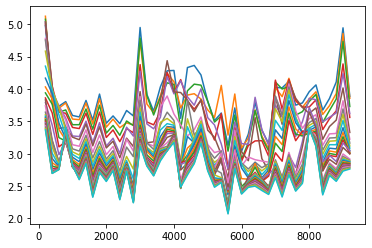

In [26]:
for i in range(len(xs)):
    plt.plot(xs[i], ys[i])

tensor([21.5459,  5.5099,  4.9950,  0.0237,  0.1341,  0.5924,  0.2855],
       grad_fn=<AddBackward0>) tensor([2.7000e+01, 4.9000e+00, 5.9000e+00, 1.8000e-02, 1.3400e-01, 5.8600e-01,
        2.7700e-01]) tensor(4.4198, grad_fn=<MseLossBackward0>)
tensor([1.5114, 1.4685, 0.4260, 0.0507, 0.1275, 0.4729, 0.0765],
       grad_fn=<AddBackward0>) tensor([0.5000, 0.8000, 0.3000, 0.0000, 0.1580, 0.2500, 0.0710]) tensor(0.2199, grad_fn=<MseLossBackward0>)
tensor([9.4651, 3.4207, 2.9553, 0.0281, 0.1052, 0.5373, 0.1654],
       grad_fn=<AddBackward0>) tensor([7.5000, 3.9000, 1.5000, 0.0160, 0.1190, 0.5400, 0.0670]) tensor(0.8884, grad_fn=<MseLossBackward0>)
tensor([12.0999,  3.4380,  2.4880,  0.0414,  0.1426,  0.5306,  0.1826],
       grad_fn=<AddBackward0>) tensor([7.1000, 3.1000, 3.8000, 0.0390, 0.1050, 0.4160, 0.2940]) tensor(3.8373, grad_fn=<MseLossBackward0>)
tensor([15.8060,  3.7780,  3.9848,  0.0201,  0.1136,  0.5496,  0.2457],
       grad_fn=<AddBackward0>) tensor([1.8800e+01, 3.2000e+00,

tensor([16.7026,  7.2457,  2.7070,  0.0698,  0.2032,  0.6123,  0.1475],
       grad_fn=<AddBackward0>) tensor([13.8000, 10.7000,  0.9000,  0.1080,  0.2620,  0.5530,  0.0440]) tensor(3.3774, grad_fn=<MseLossBackward0>)
tensor([15.2497,  4.0787,  3.9729,  0.0192,  0.1089,  0.5598,  0.2295],
       grad_fn=<AddBackward0>) tensor([15.3000,  5.5000,  2.2000,  0.0270,  0.1590,  0.5520,  0.1190]) tensor(0.7401, grad_fn=<MseLossBackward0>)
tensor([11.5952,  4.1178,  2.8838,  0.0360,  0.1285,  0.5481,  0.1717],
       grad_fn=<AddBackward0>) tensor([1.5400e+01, 3.3000e+00, 2.8000e+00, 1.4000e-02, 9.3000e-02, 5.5300e-01,
        1.3200e-01]) tensor(2.1651, grad_fn=<MseLossBackward0>)
tensor([ 5.4863,  4.7068, -0.2494,  0.0920,  0.2171,  0.5322,  0.0336],
       grad_fn=<AddBackward0>) tensor([4.4000, 3.0000, 0.3000, 0.0840, 0.2110, 0.5970, 0.0380]) tensor(0.6285, grad_fn=<MseLossBackward0>)
tensor([10.5453,  3.8209,  2.6566,  0.0330,  0.1220,  0.5372,  0.1637],
       grad_fn=<AddBackward0>) ten

       grad_fn=<AddBackward0>) tensor([13.8000,  2.8000,  2.8000,  0.0160,  0.0990,  0.5510,  0.1590]) tensor(1.1333, grad_fn=<MseLossBackward0>)
tensor([8.3208, 5.2526, 1.3328, 0.0688, 0.1776, 0.5587, 0.0801],
       grad_fn=<AddBackward0>) tensor([2.6000, 3.2000, 0.6000, 0.0960, 0.1570, 0.4390, 0.0600]) tensor(5.3563, grad_fn=<MseLossBackward0>)
tensor([14.4831,  5.7125,  2.4753,  0.0652,  0.1908,  0.5619,  0.1670],
       grad_fn=<AddBackward0>) tensor([17.9000,  8.5000,  3.1000,  0.0720,  0.2150,  0.5450,  0.1600]) tensor(2.8338, grad_fn=<MseLossBackward0>)
tensor([8.8631, 4.0558, 1.3688, 0.0599, 0.1674, 0.5288, 0.1167],
       grad_fn=<AddBackward0>) tensor([7.0000, 4.3000, 0.5000, 0.1180, 0.1600, 0.6970, 0.0510]) tensor(0.6174, grad_fn=<MseLossBackward0>)
tensor([13.5977,  5.4863,  2.3444,  0.0610,  0.1803,  0.5742,  0.1484],
       grad_fn=<AddBackward0>) tensor([12.4000,  5.7000,  3.2000,  0.0550,  0.1500,  0.5470,  0.1650]) tensor(0.3163, grad_fn=<MseLossBackward0>)
tensor([8.

       grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0.]) tensor(5.5309, grad_fn=<MseLossBackward0>)
tensor([12.6006,  3.1833,  3.3809,  0.0264,  0.1140,  0.5299,  0.2152],
       grad_fn=<AddBackward0>) tensor([1.2100e+01, 2.7000e+00, 2.9000e+00, 1.1000e-02, 9.1000e-02, 4.6000e-01,
        1.4900e-01]) tensor(0.1037, grad_fn=<MseLossBackward0>)
tensor([4.7876, 1.0699, 1.4235, 0.0320, 0.1080, 0.4653, 0.1456],
       grad_fn=<AddBackward0>) tensor([4.8000, 2.0000, 1.5000, 0.0140, 0.1470, 0.5590, 0.2310]) tensor(0.1270, grad_fn=<MseLossBackward0>)
tensor([12.5010,  4.7227,  2.3476,  0.0483,  0.1578,  0.5596,  0.1545],
       grad_fn=<AddBackward0>) tensor([4.1000, 2.1000, 0.4000, 0.0690, 0.1640, 0.4990, 0.0800]) tensor(11.6085, grad_fn=<MseLossBackward0>)
tensor([5.7183, 2.4744, 0.8885, 0.0534, 0.1500, 0.4932, 0.1112],
       grad_fn=<AddBackward0>) tensor([1.5000, 1.1000, 0.2000, 0.0430, 0.1520, 0.3160, 0.0430]) tensor(2.8848, grad_fn=<MseLossBackward0>)
tensor([12.0325,  6.17

tensor([9.4433, 4.3105, 1.5026, 0.0617, 0.1719, 0.5262, 0.1247],
       grad_fn=<AddBackward0>) tensor([7.8000, 4.7000, 1.7000, 0.0960, 0.1250, 0.4880, 0.1170]) tensor(0.4137, grad_fn=<MseLossBackward0>)
tensor([12.5894,  5.1405,  2.3377,  0.0547,  0.1669,  0.5607,  0.1490],
       grad_fn=<AddBackward0>) tensor([9.0000, 3.9000, 1.9000, 0.0400, 0.1400, 0.4710, 0.1380]) tensor(2.0890, grad_fn=<MseLossBackward0>)
tensor([8.2564, 0.9337, 2.4349, 0.0244, 0.1049, 0.4479, 0.2203],
       grad_fn=<AddBackward0>) tensor([8.1000, 1.1000, 1.9000, 0.0230, 0.0400, 0.4370, 0.1980]) tensor(0.0490, grad_fn=<MseLossBackward0>)
tensor([10.1955,  3.4237,  2.1098,  0.0389,  0.1366,  0.5231,  0.1594],
       grad_fn=<AddBackward0>) tensor([8.9000, 2.5000, 2.1000, 0.0260, 0.1140, 0.4980, 0.1740]) tensor(0.3619, grad_fn=<MseLossBackward0>)
tensor([15.9136,  5.2067,  3.7575,  0.0364,  0.1391,  0.5802,  0.2071],
       grad_fn=<AddBackward0>) tensor([11.2000,  2.3000,  4.1000,  0.0120,  0.0890,  0.5570,  0.26

       grad_fn=<AddBackward0>) tensor([8.1000, 5.0000, 0.7000, 0.0940, 0.1910, 0.6070, 0.0650]) tensor(3.7664, grad_fn=<MseLossBackward0>)
tensor([9.1626, 1.7539, 3.0059, 0.0141, 0.0855, 0.4811, 0.2136],
       grad_fn=<AddBackward0>) tensor([9.5000e+00, 1.8000e+00, 4.2000e+00, 9.0000e-03, 7.5000e-02, 5.3700e-01,
        2.7300e-01]) tensor(0.2212, grad_fn=<MseLossBackward0>)
tensor([13.6922,  4.6567,  2.5602,  0.0497,  0.1628,  0.5602,  0.1725],
       grad_fn=<AddBackward0>) tensor([10.2000,  5.5000,  0.7000,  0.0970,  0.2150,  0.5360,  0.0640]) tensor(2.3406, grad_fn=<MseLossBackward0>)
tensor([7.8072, 3.9419, 1.6455, 0.0549, 0.1535, 0.5239, 0.1194],
       grad_fn=<AddBackward0>) tensor([10.8000, 10.4000,  1.5000,  0.1040,  0.2690,  0.5930,  0.0650]) tensor(7.2441, grad_fn=<MseLossBackward0>)
tensor([12.9268,  4.3177,  3.0849,  0.0376,  0.1337,  0.5559,  0.1827],
       grad_fn=<AddBackward0>) tensor([12.4000,  6.1000,  5.5000,  0.0280,  0.1620,  0.5370,  0.2410]) tensor(1.3274, gr

       grad_fn=<AddBackward0>) tensor([7.1000, 6.0000, 1.1000, 0.0790, 0.2210, 0.4780, 0.0760]) tensor(5.4003, grad_fn=<MseLossBackward0>)
tensor([ 1.7814,  2.0894, -0.1844,  0.0638,  0.1582,  0.4695,  0.0605],
       grad_fn=<AddBackward0>) tensor([4.0000, 4.0000, 0.6000, 0.0630, 0.1930, 0.6820, 0.0630]) tensor(1.3192, grad_fn=<MseLossBackward0>)
tensor([11.6007,  5.6023,  1.0998,  0.0863,  0.2234,  0.5603,  0.1054],
       grad_fn=<AddBackward0>) tensor([20.7000,  6.0000,  0.9000,  0.0880,  0.1260,  0.6290,  0.0590]) tensor(11.8588, grad_fn=<MseLossBackward0>)
tensor([13.3427,  6.4409,  2.2787,  0.0665,  0.1859,  0.5994,  0.1179],
       grad_fn=<AddBackward0>) tensor([7.8000, 9.0000, 0.8000, 0.1330, 0.2330, 0.6110, 0.0400]) tensor(5.6385, grad_fn=<MseLossBackward0>)
tensor([4.6348, 1.4121, 1.0417, 0.0405, 0.1268, 0.4508, 0.1395],
       grad_fn=<AddBackward0>) tensor([2.3000, 0.6000, 0.4000, 0.0240, 0.0700, 0.5470, 0.1070]) tensor(0.9338, grad_fn=<MseLossBackward0>)
tensor([14.8279,

       grad_fn=<AddBackward0>) tensor([5.7000, 3.6000, 1.3000, 0.0590, 0.1330, 0.4480, 0.0930]) tensor(0.0481, grad_fn=<MseLossBackward0>)
tensor([12.4752,  3.0068,  3.6424,  0.0194,  0.0990,  0.5324,  0.2205],
       grad_fn=<AddBackward0>) tensor([6.4000, 1.3000, 2.0000, 0.0210, 0.0680, 0.5500, 0.2230]) tensor(6.0744, grad_fn=<MseLossBackward0>)
tensor([14.7450,  4.5568,  3.5201,  0.0292,  0.1255,  0.5621,  0.2045],
       grad_fn=<AddBackward0>) tensor([12.0000,  3.4000,  6.8000,  0.0170,  0.0890,  0.5100,  0.3200]) tensor(2.8069, grad_fn=<MseLossBackward0>)
tensor([7.9583, 2.2780, 1.8937, 0.0363, 0.1247, 0.4922, 0.1616],
       grad_fn=<AddBackward0>) tensor([3.0000, 0.9000, 0.3000, 0.0540, 0.0620, 0.4210, 0.0790]) tensor(4.1485, grad_fn=<MseLossBackward0>)
tensor([12.9183,  6.6149,  1.6348,  0.0784,  0.2099,  0.5939,  0.0997],
       grad_fn=<AddBackward0>) tensor([12.1000,  6.9000,  1.1000,  0.0920,  0.1850,  0.5770,  0.0670]) tensor(0.1485, grad_fn=<MseLossBackward0>)
tensor([10

       grad_fn=<AddBackward0>) tensor([9.2000, 4.0000, 1.0000, 0.0270, 0.1380, 0.4690, 0.0590]) tensor(0.4833, grad_fn=<MseLossBackward0>)
tensor([12.0570,  4.9285,  2.4625,  0.0519,  0.1589,  0.5534,  0.1531],
       grad_fn=<AddBackward0>) tensor([6.5000, 1.8000, 1.7000, 0.0200, 0.0840, 0.5010, 0.1340]) tensor(5.8941, grad_fn=<MseLossBackward0>)
tensor([10.3458,  3.6840,  2.5415,  0.0409,  0.1342,  0.5371,  0.1625],
       grad_fn=<AddBackward0>) tensor([10.9000,  3.8000,  4.4000,  0.0170,  0.1210,  0.5280,  0.2260]) tensor(0.5399, grad_fn=<MseLossBackward0>)
tensor([7.6948, 1.3595, 1.7099, 0.0335, 0.1284, 0.4334, 0.2001],
       grad_fn=<AddBackward0>) tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.4290, 0.0000, 0.0000]) tensor(8.9403, grad_fn=<MseLossBackward0>)
tensor([4.9399, 3.6471, 0.6993, 0.0648, 0.1639, 0.5176, 0.0715],
       grad_fn=<AddBackward0>) tensor([2.6000, 1.4000, 0.8000, 0.0150, 0.1120, 0.4230, 0.0930]) tensor(1.5070, grad_fn=<MseLossBackward0>)
tensor([10.9476,  3.5599

       grad_fn=<AddBackward0>) tensor([4.6000, 5.9000, 0.9000, 0.1350, 0.1930, 0.4730, 0.0740]) tensor(0.5908, grad_fn=<MseLossBackward0>)
tensor([12.5632,  6.5087,  1.4610,  0.0833,  0.2179,  0.5841,  0.0987],
       grad_fn=<AddBackward0>) tensor([7.6000, 6.7000, 0.5000, 0.1760, 0.3390, 0.6020, 0.0580]) tensor(3.6598, grad_fn=<MseLossBackward0>)
tensor([4.1620, 1.7346, 0.3225, 0.0575, 0.1562, 0.4599, 0.1085],
       grad_fn=<AddBackward0>) tensor([8.8000, 3.5000, 0.3000, 0.0220, 0.1400, 0.4580, 0.0150]) tensor(3.5198, grad_fn=<MseLossBackward0>)
tensor([1.3560e+01, 2.8261e+00, 4.3025e+00, 3.8349e-03, 7.6126e-02, 5.2751e-01,
        2.5328e-01], grad_fn=<AddBackward0>) tensor([7.2000, 1.4000, 1.8000, 0.0130, 0.0920, 0.5520, 0.2030]) tensor(6.9635, grad_fn=<MseLossBackward0>)
tensor([12.9290,  6.3380,  1.8246,  0.0759,  0.2046,  0.5880,  0.1116],
       grad_fn=<AddBackward0>) tensor([12.1000,  9.1000,  1.4000,  0.1230,  0.2130,  0.5610,  0.0770]) tensor(1.2144, grad_fn=<MseLossBackwar

       grad_fn=<AddBackward0>) tensor([3.9000, 2.3000, 0.4000, 0.1060, 0.1220, 0.4910, 0.0580]) tensor(1.3074, grad_fn=<MseLossBackward0>)
tensor([8.0230, 3.5123, 1.6047, 0.0503, 0.1478, 0.5201, 0.1254],
       grad_fn=<AddBackward0>) tensor([2.1000, 2.0000, 0.6000, 0.0770, 0.2020, 0.4320, 0.1250]) tensor(5.4843, grad_fn=<MseLossBackward0>)
tensor([14.6448,  6.4237,  2.5038,  0.0706,  0.1981,  0.5908,  0.1455],
       grad_fn=<AddBackward0>) tensor([16.1000, 10.5000,  2.2000,  0.1150,  0.2590,  0.5380,  0.1110]) tensor(2.6908, grad_fn=<MseLossBackward0>)
tensor([3.0188, 1.4964, 0.9143, 0.0402, 0.1160, 0.4762, 0.1031],
       grad_fn=<AddBackward0>) tensor([4.7000, 3.5000, 0.4000, 0.0580, 0.1610, 0.5850, 0.0410]) tensor(1.0176, grad_fn=<MseLossBackward0>)
tensor([13.1110,  5.3864,  2.4547,  0.0568,  0.1698,  0.5635,  0.1522],
       grad_fn=<AddBackward0>) tensor([6.2000, 5.0000, 1.9000, 0.0530, 0.1970, 0.4980, 0.1270]) tensor(6.8893, grad_fn=<MseLossBackward0>)
tensor([1.5947e+01, 3.63

       grad_fn=<AddBackward0>) tensor([12.7000, 13.8000,  1.2000,  0.1360,  0.3430,  0.6730,  0.0540]) tensor(7.7871, grad_fn=<MseLossBackward0>)
tensor([15.3924,  4.0215,  4.1818,  0.0209,  0.1106,  0.5454,  0.2457],
       grad_fn=<AddBackward0>) tensor([8.7000, 2.3000, 1.4000, 0.0410, 0.0720, 0.5450, 0.0920]) tensor(7.9307, grad_fn=<MseLossBackward0>)
tensor([12.3826,  3.0511,  3.4820,  0.0270,  0.1144,  0.5031,  0.2331],
       grad_fn=<AddBackward0>) tensor([6.5000, 2.1000, 1.7000, 0.0260, 0.1050, 0.5130, 0.1410]) tensor(5.5277, grad_fn=<MseLossBackward0>)
tensor([6.0480, 0.2777, 1.8716, 0.0110, 0.0841, 0.4348, 0.1966],
       grad_fn=<AddBackward0>) tensor([1.2000, 0.3000, 0.1000, 0.0000, 0.1180, 0.3370, 0.0670]) tensor(3.8100, grad_fn=<MseLossBackward0>)
tensor([13.4911,  5.5061,  2.4477,  0.0526,  0.1656,  0.5761,  0.1466],
       grad_fn=<AddBackward0>) tensor([8.6000, 2.9000, 0.7000, 0.0470, 0.1080, 0.5540, 0.0480]) tensor(4.8261, grad_fn=<MseLossBackward0>)
tensor([14.4311, 

       grad_fn=<AddBackward0>) tensor([10.7000,  8.9000,  0.8000,  0.1160,  0.2350,  0.5810,  0.0410]) tensor(1.6269, grad_fn=<MseLossBackward0>)
tensor([ 3.2261,  3.8829, -0.1752,  0.0819,  0.1913,  0.5159,  0.0319],
       grad_fn=<AddBackward0>) tensor([5.6000, 4.8000, 0.6000, 0.0980, 0.2040, 0.6010, 0.0500]) tensor(1.0122, grad_fn=<MseLossBackward0>)
tensor([15.7975,  4.3588,  4.0292,  0.0252,  0.1193,  0.5625,  0.2318],
       grad_fn=<AddBackward0>) tensor([13.0000,  4.7000,  8.8000,  0.0230,  0.1280,  0.5350,  0.3770]) tensor(4.3893, grad_fn=<MseLossBackward0>)
tensor([12.1911,  4.5803,  2.9324,  0.0429,  0.1397,  0.5548,  0.1694],
       grad_fn=<AddBackward0>) tensor([11.9000,  3.7000,  2.2000,  0.0220,  0.0890,  0.5610,  0.0850]) tensor(0.2009, grad_fn=<MseLossBackward0>)
tensor([-4.0269,  0.7363, -0.7608,  0.0564,  0.1280,  0.4373,  0.0216],
       grad_fn=<AddBackward0>) tensor([2.5000, 3.5000, 0.0000, 0.0570, 0.1350, 0.5250, 0.0000]) tensor(7.2608, grad_fn=<MseLossBackward

       grad_fn=<AddBackward0>) tensor([5.5000, 2.2000, 4.5000, 0.0240, 0.0900, 0.4950, 0.3010]) tensor(5.4899, grad_fn=<MseLossBackward0>)
tensor([7.4441, 5.3324, 0.1937, 0.0976, 0.2324, 0.5248, 0.0639],
       grad_fn=<AddBackward0>) tensor([4.0000, 2.3000, 0.6000, 0.0700, 0.1230, 0.4730, 0.0690]) tensor(3.0340, grad_fn=<MseLossBackward0>)
tensor([10.0044,  4.8027,  1.9765,  0.0600,  0.1662,  0.5583,  0.1207],
       grad_fn=<AddBackward0>) tensor([4.6000, 2.1000, 0.7000, 0.0680, 0.1190, 0.5380, 0.0790]) tensor(5.4495, grad_fn=<MseLossBackward0>)
tensor([17.5311,  4.7211,  4.3335,  0.0236,  0.1237,  0.5697,  0.2507],
       grad_fn=<AddBackward0>) tensor([2.0400e+01, 3.3000e+00, 2.5000e+00, 1.5000e-02, 8.6000e-02, 5.4000e-01,
        1.2300e-01]) tensor(1.9473, grad_fn=<MseLossBackward0>)
tensor([12.9284,  6.4217,  1.9846,  0.0710,  0.1955,  0.6003,  0.1081],
       grad_fn=<AddBackward0>) tensor([8.4000, 6.5000, 0.8000, 0.0930, 0.1790, 0.5210, 0.0490]) tensor(3.1324, grad_fn=<MseLoss

       grad_fn=<AddBackward0>) tensor([2.1000, 0.4000, 0.4000, 0.0600, 0.0260, 0.5060, 0.1540]) tensor(5.1408, grad_fn=<MseLossBackward0>)
tensor([ 5.3793,  4.4900, -0.3769,  0.0900,  0.2199,  0.5027,  0.0487],
       grad_fn=<AddBackward0>) tensor([1.7000, 1.3000, 0.0000, 0.0000, 0.3330, 0.7530, 0.0000]) tensor(3.4202, grad_fn=<MseLossBackward0>)
tensor([8.5276, 3.0184, 2.4049, 0.0367, 0.1203, 0.5125, 0.1610],
       grad_fn=<AddBackward0>) tensor([11.7000,  4.4000,  1.6000,  0.0140,  0.1160,  0.5670,  0.0660]) tensor(1.8048, grad_fn=<MseLossBackward0>)
tensor([9.4915, 3.8869, 1.8006, 0.0526, 0.1569, 0.5246, 0.1389],
       grad_fn=<AddBackward0>) tensor([3.3000, 1.4000, 0.5000, 0.0320, 0.1110, 0.4450, 0.0810]) tensor(6.6034, grad_fn=<MseLossBackward0>)
tensor([11.9385,  3.0094,  3.4871,  0.0163,  0.0950,  0.5263,  0.2142],
       grad_fn=<AddBackward0>) tensor([12.2000,  4.0000,  2.1000,  0.0130,  0.1140,  0.5130,  0.0970]) tensor(0.4269, grad_fn=<MseLossBackward0>)
tensor([6.6208, 4

       grad_fn=<AddBackward0>) tensor([4.7000, 3.3000, 0.7000, 0.0810, 0.1710, 0.5670, 0.0760]) tensor(0.3822, grad_fn=<MseLossBackward0>)
tensor([11.2219,  3.2948,  2.3476,  0.0356,  0.1329,  0.5310,  0.1728],
       grad_fn=<AddBackward0>) tensor([4.5000, 1.8000, 1.3000, 0.0900, 0.0910, 0.4620, 0.1860]) tensor(6.9323, grad_fn=<MseLossBackward0>)
tensor([9.2296, 3.4328, 1.9681, 0.0425, 0.1373, 0.5312, 0.1414],
       grad_fn=<AddBackward0>) tensor([9.1000, 2.1000, 1.5000, 0.0150, 0.0900, 0.5440, 0.1110]) tensor(0.2881, grad_fn=<MseLossBackward0>)
tensor([18.3856,  5.9220,  4.0563,  0.0401,  0.1527,  0.5943,  0.2234],
       grad_fn=<AddBackward0>) tensor([16.9000,  6.4000,  9.8000,  0.0330,  0.1510,  0.5100,  0.4190]) tensor(5.0673, grad_fn=<MseLossBackward0>)
tensor([10.1635,  3.2600,  2.5395,  0.0362,  0.1269,  0.5127,  0.1773],
       grad_fn=<AddBackward0>) tensor([5.7000, 1.2000, 0.7000, 0.0160, 0.0650, 0.5270, 0.0630]) tensor(3.9382, grad_fn=<MseLossBackward0>)
tensor([8.6917, 3

       grad_fn=<AddBackward0>) tensor([6.9000, 2.1000, 3.6000, 0.0240, 0.1090, 0.5440, 0.3160]) tensor(5.6299, grad_fn=<MseLossBackward0>)
tensor([1.5125e+01, 3.5873e+00, 4.5520e+00, 7.3337e-03, 8.3191e-02, 5.5383e-01,
        2.5066e-01], grad_fn=<AddBackward0>) tensor([9.6000, 3.6000, 5.3000, 0.0250, 0.1000, 0.4720, 0.2670]) tensor(4.4422, grad_fn=<MseLossBackward0>)
tensor([12.4585,  4.8615,  2.8294,  0.0484,  0.1514,  0.5542,  0.1679],
       grad_fn=<AddBackward0>) tensor([10.5000,  8.6000,  1.9000,  0.0970,  0.1860,  0.5270,  0.0970]) tensor(2.6693, grad_fn=<MseLossBackward0>)
tensor([7.0985, 3.2751, 1.1820, 0.0548, 0.1542, 0.5139, 0.1112],
       grad_fn=<AddBackward0>) tensor([7.7000, 4.6000, 2.8000, 0.0200, 0.1820, 0.5080, 0.1650]) tensor(0.6771, grad_fn=<MseLossBackward0>)
tensor([7.3428, 2.5222, 1.7449, 0.0442, 0.1359, 0.4874, 0.1530],
       grad_fn=<AddBackward0>) tensor([7.8000, 3.9000, 1.0000, 0.0510, 0.1150, 0.4570, 0.0590]) tensor(0.3818, grad_fn=<MseLossBackward0>)
te

tensor([15.9643,  6.2242,  3.2603,  0.0529,  0.1688,  0.5985,  0.1736],
       grad_fn=<AddBackward0>) tensor([10.6000,  4.1000,  1.8000,  0.0400,  0.1340,  0.5230,  0.1020]) tensor(5.0618, grad_fn=<MseLossBackward0>)
tensor([1.6526e+01, 3.6961e+00, 4.5406e+00, 1.1393e-02, 9.7757e-02, 5.4349e-01,
        2.7015e-01], grad_fn=<AddBackward0>) tensor([11.3000,  2.8000,  4.0000,  0.0210,  0.1190,  0.5100,  0.3010]) tensor(4.0585, grad_fn=<MseLossBackward0>)
tensor([2.8647, 3.1683, 0.2442, 0.0685, 0.1669, 0.4977, 0.0575],
       grad_fn=<AddBackward0>) tensor([4.0000, 5.3000, 0.9000, 0.1140, 0.2510, 0.4610, 0.0880]) tensor(0.8964, grad_fn=<MseLossBackward0>)
tensor([10.4360,  2.5137,  3.0888,  0.0279,  0.1112,  0.5044,  0.2110],
       grad_fn=<AddBackward0>) tensor([9.6000, 2.5000, 3.1000, 0.0280, 0.1150, 0.5730, 0.2340]) tensor(0.1006, grad_fn=<MseLossBackward0>)
tensor([12.5035,  4.0033,  3.1693,  0.0371,  0.1315,  0.5488,  0.1903],
       grad_fn=<AddBackward0>) tensor([10.1000,  3.2000

       grad_fn=<AddBackward0>) tensor([17.6000,  6.2000,  2.5000,  0.0480,  0.1580,  0.5350,  0.1200]) tensor(0.3629, grad_fn=<MseLossBackward0>)
tensor([10.4846,  5.9760,  1.4000,  0.0759,  0.1978,  0.5713,  0.0890],
       grad_fn=<AddBackward0>) tensor([4.0000, 3.4000, 0.4000, 0.0560, 0.2000, 0.4980, 0.0400]) tensor(7.0992, grad_fn=<MseLossBackward0>)
tensor([10.3910,  3.0825,  3.0727,  0.0232,  0.1016,  0.5275,  0.1865],
       grad_fn=<AddBackward0>) tensor([12.4000,  2.6000,  5.3000,  0.0190,  0.0720,  0.6100,  0.2570]) tensor(1.3204, grad_fn=<MseLossBackward0>)
tensor([9.9676, 1.8899, 2.4440, 0.0299, 0.1184, 0.4925, 0.2010],
       grad_fn=<AddBackward0>) tensor([1.2000, 0.2000, 0.2000, 0.0670, 0.0000, 0.5100, 0.1110]) tensor(12.1123, grad_fn=<MseLossBackward0>)
tensor([9.0834, 5.3029, 1.1731, 0.0735, 0.1899, 0.5640, 0.0811],
       grad_fn=<AddBackward0>) tensor([9.6000, 6.7000, 0.9000, 0.1280, 0.1230, 0.5740, 0.0500]) tensor(0.3289, grad_fn=<MseLossBackward0>)
tensor([11.5586,

       grad_fn=<AddBackward0>) tensor([10.4000,  6.4000,  1.6000,  0.0950,  0.2100,  0.5380,  0.1120]) tensor(4.4626, grad_fn=<MseLossBackward0>)
tensor([9.4105, 4.9088, 1.6267, 0.0579, 0.1633, 0.5558, 0.1028],
       grad_fn=<AddBackward0>) tensor([4.6000, 6.6000, 0.8000, 0.1250, 0.2110, 0.4860, 0.0540]) tensor(3.8141, grad_fn=<MseLossBackward0>)
tensor([-5.2529e+00,  4.6575e-01, -1.1586e+00,  5.6866e-02,  1.2549e-01,
         4.3384e-01,  1.9494e-03], grad_fn=<AddBackward0>) tensor([0., 0., 0., 0., 0., 0., 0.]) tensor(4.1943, grad_fn=<MseLossBackward0>)
tensor([12.2857,  5.6871,  1.7360,  0.0700,  0.1957,  0.5734,  0.1197],
       grad_fn=<AddBackward0>) tensor([6.1000, 3.0000, 0.5000, 0.0910, 0.1680, 0.5390, 0.0730]) tensor(6.7165, grad_fn=<MseLossBackward0>)
tensor([16.2162,  7.3310,  2.2242,  0.0781,  0.2190,  0.6097,  0.1312],
       grad_fn=<AddBackward0>) tensor([20.2000, 15.2000,  2.5000,  0.1360,  0.3360,  0.5930,  0.1160]) tensor(11.1264, grad_fn=<MseLossBackward0>)
tensor([

(array([620., 445., 311., 237., 170., 143., 106.,  67.,  56.,  50.,  36.,
         21.,  18.,  11.,  12.,   5.,   5.,   7.,   1.,   3.,   3.,   3.,
          1.,   4.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <BarContainer object of 24 artists>)

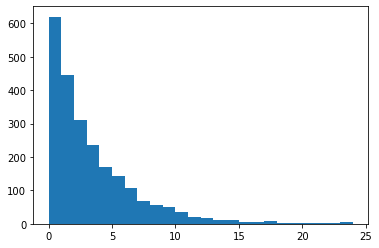

In [34]:
l = []
x = []
for i in range(len(test_x)):
    print(neural(test_x[i]), test_y[i], loss(neural(test_x[i]), test_y[i]))
    l.append(loss(neural(test_x[i]), test_y[i]).item())
    x.append(i)
plt.hist(l, range(0,25))

K-fold validation

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.semilogy(range(1, num_epochs + 1), train_ls)
            plt.semilogy(range(1, num_epochs + 1), valid_ls)
            plt.legend(['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k